In [8]:
import matplotlib.pyplot as plt
import cyipopt as ipopt
import numpy as np

from vessel_models import VesselModel
from controller import TrajOpt

In [9]:
# Validating IPOPT
from scipy.optimize import rosen, rosen_der
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = ipopt.minimize_ipopt(rosen, x0, jac=rosen_der)
print(res)

 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 2.1081754165231008e-18
       x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00  1.000e+00]
     nit: 37
    info:     status: 0
                   x: [ 1.000e+00  1.000e+00  1.000e+00  1.000e+00
                        1.000e+00]
                   g: []
             obj_val: 2.1081754165231008e-18
              mult_g: []
            mult_x_L: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                        0.000e+00]
            mult_x_U: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00
                        0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 200
    njev: 39


In [10]:
# Simulation variables
N = 120
dt = 0.5
ns = 6
nu = 3

# Cost matrices
Qvec = 3*np.ones(ns)
Rvec = 0.1*np.ones(nu)
Qfvec = 10*np.ones(ns)

# Problem Definition
s0 = np.zeros(6)
sf = np.zeros(6)
sf[0] = 10
sf[1] = 10
sf[2] = np.pi/2

# obstacles
num_obstacles = 1
obstacles = np.zeros((num_obstacles, 3))
obstacles[0] = [5, 5, 2]

In [11]:
model = VesselModel(mismatch=False)
trajoptimizer = TrajOpt(model, N, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf, obstacles)
trajoptimizer.exec_trajopt()

This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:   781902
Number of nonzeros in inequality constraint Jacobian.:   898218
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1077
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      726
Total number of inequality constraints...............:      834
        inequality constraints with only lower bounds:      834
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7152768e+04 1.00e+01 4.82e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
   

KeyboardInterrupt: 

 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
 success: True
  status: 0
     fun: 407.8027785227915
       x: [ 1.742e-32 -1.406e-35 ...  7.865e-01  1.791e-01]
     nit: 130
    info:     status: 0
                   x: [ 1.742e-32 -1.406e-35 ...  7.865e-01  1.791e-01]
                   g: [ 1.559e-13 -2.966e-14 ...  1.147e-01  1.150e-01]
             obj_val: 407.8027785227915
              mult_g: [ 2.234e+02 -5.868e+02 ... -1.440e-07 -1.305e-07]
            mult_x_L: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            mult_x_U: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
          status_msg: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 145
    njev: 119
3.4534536079078473


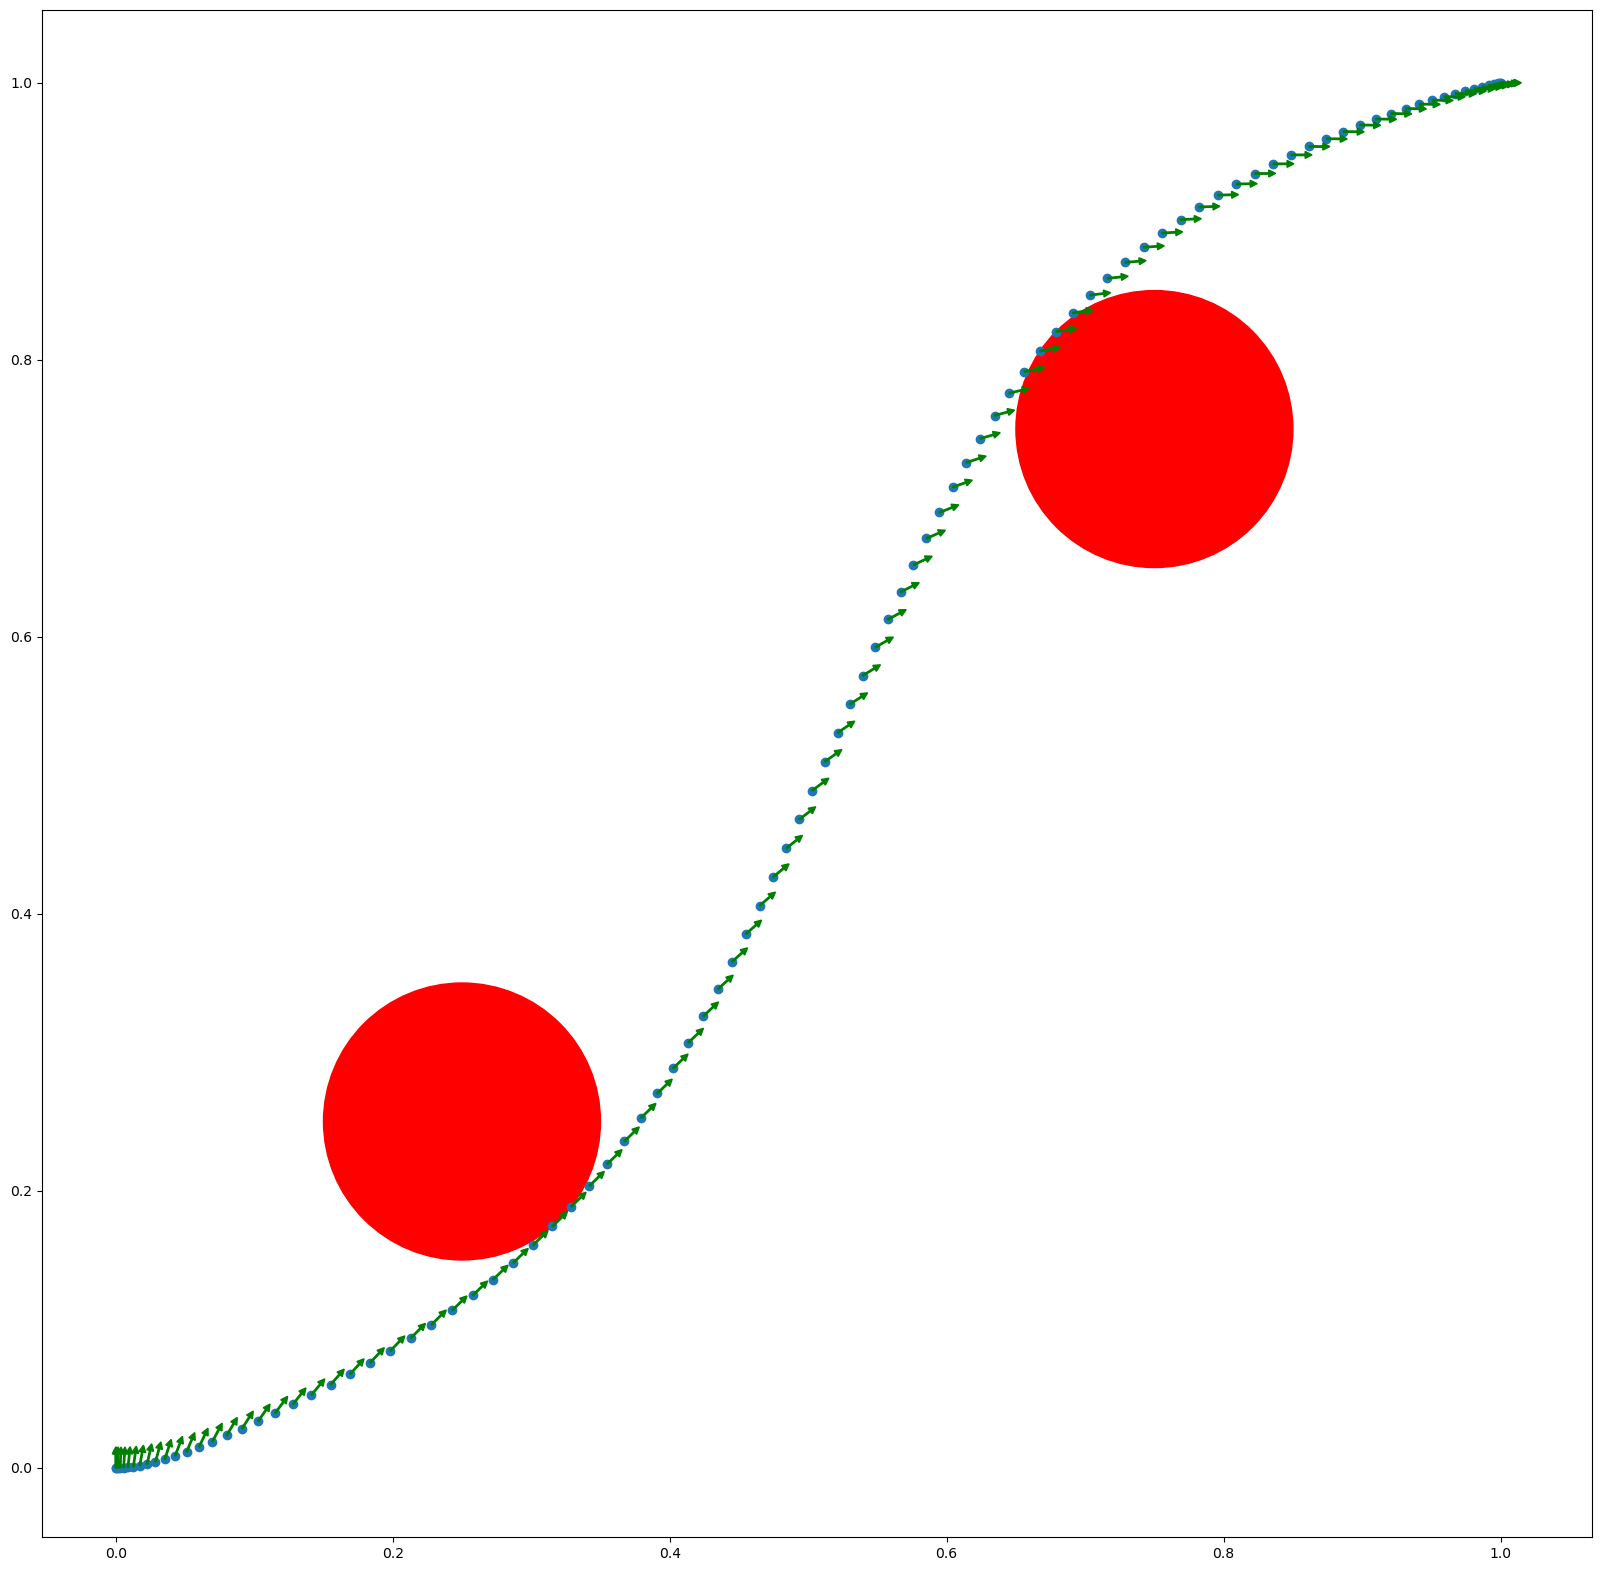

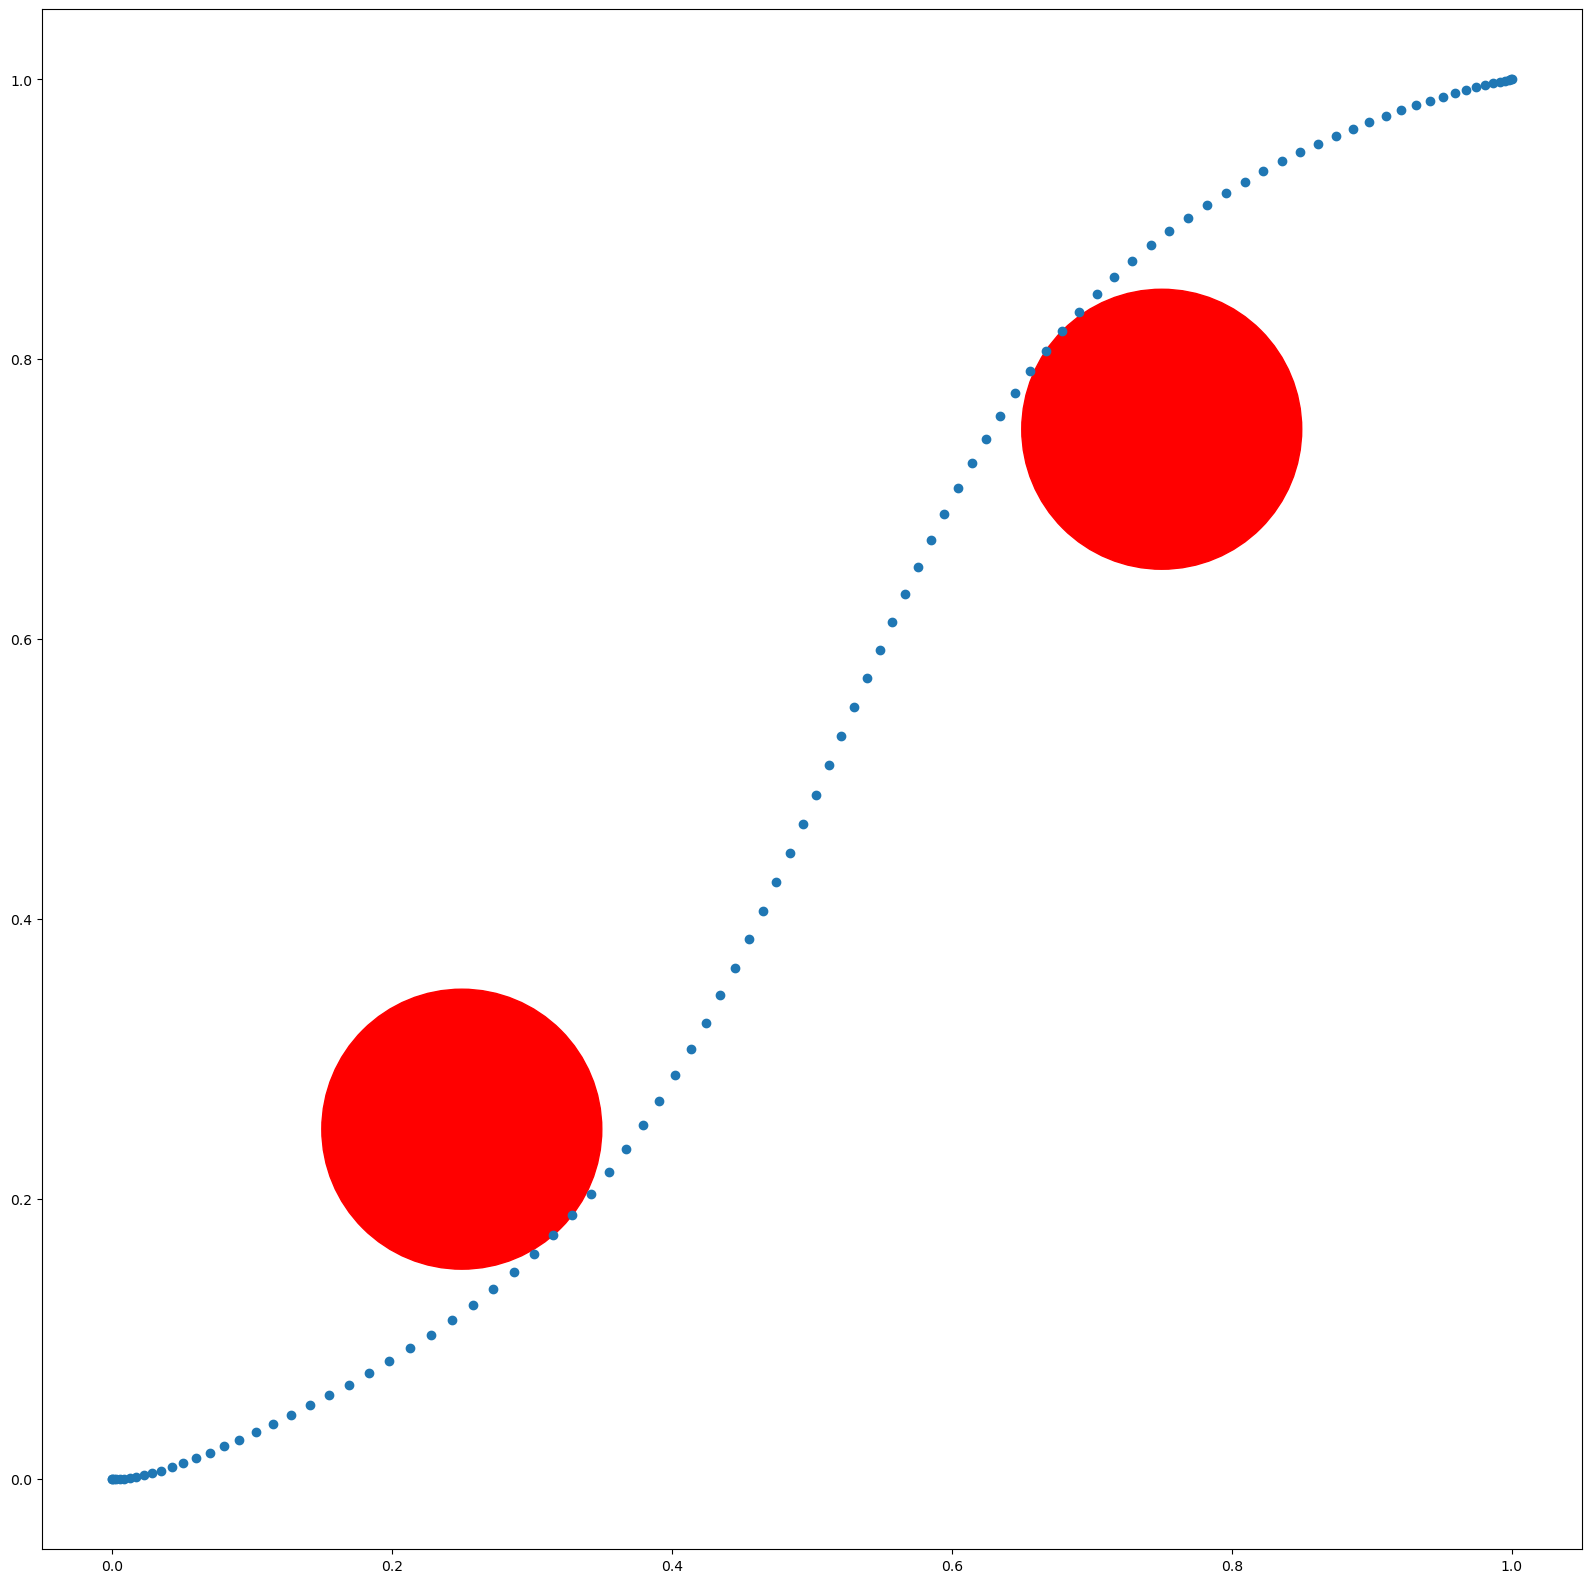

In [ ]:
print(trajoptimizer.sol)
S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
print(np.max(U))
ps = S.T

np.savetxt("dircol_soln.csv", S, delimiter=",")
np.savetxt("dircol_inpu.csv", U, delimiter=",")

fig, axes = plt.subplots(1, 1, figsize=(20, 20))

for obstacle in obstacles:
    obs_x, obs_y, obs_r = obstacle
    circle = plt.Circle((obs_y, obs_x), obs_r, color='r')
    axes.add_patch(circle)

axes.scatter(ps[1], ps[0])

for i in range(len(ps[1])):
    dx = 0.01*np.cos(ps[2,i])
    dy = 0.01*np.sin(ps[2,i])
    axes.arrow(ps[1,i], ps[0, i], dy, dx, head_width=0.005, head_length=0.005, fc='green', ec='green')

axes.set_aspect('equal', adjustable='box')
plt.show()

Sfwd = np.zeros((N,ns))
Sfwd[0] = S[0]
for i in range(N-1):
    Sn = Sfwd[i]
    Un = U[i]
    Sfwd[i+1] = model.rk4(Sn, Un, dt)

ps = Sfwd.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
for obstacle in obstacles:
    obs_x, obs_y, obs_r = obstacle
    circle = plt.Circle((obs_y, obs_x), obs_r, color='r')
    axes.add_patch(circle)
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()

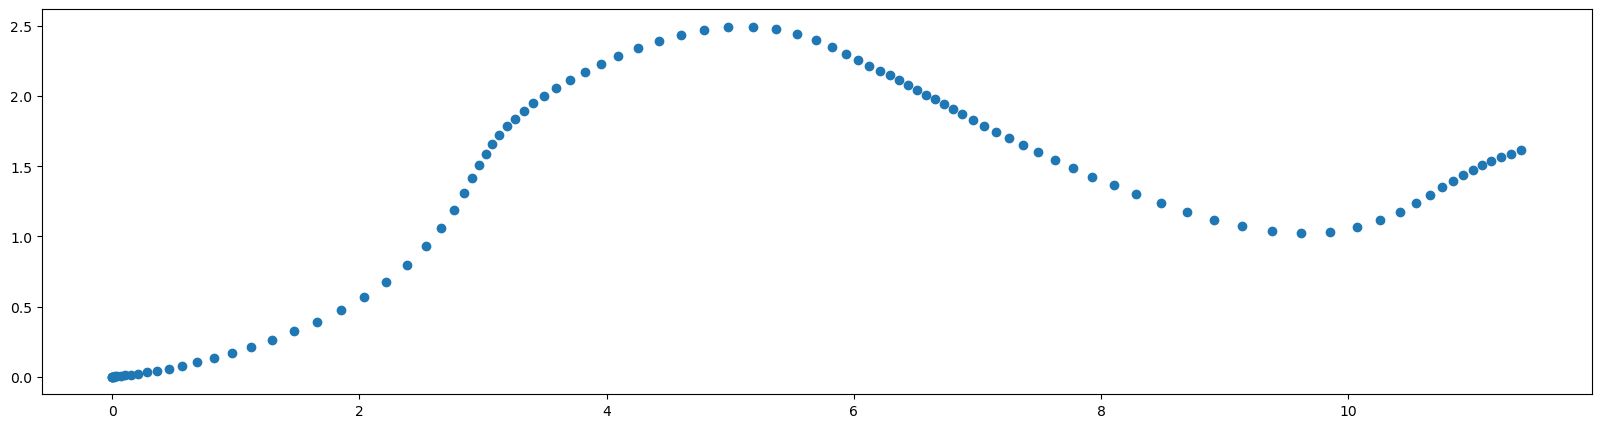

In [ ]:
Sn = np.zeros(6)
Un = np.zeros(3)
Un[0] = 5
Un[1] = 5

S = np.zeros((N, ns))
S[0] = Sn

U = np.zeros((N-1, nu))
for i in range(N-1):
    U[i] = [40*np.sin(dt*i),np.cos(dt*i),np.cos(dt*i)]

for i in range(N-1):
    S[i+1] = model.rk4(S[i], U[i], dt)

ps = list(zip(*S))
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
axes.scatter(ps[0], ps[1])
plt.show()